In [1]:
# sets the cells width of current notebook 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [1]:
import torch
import torch.nn as nn
torch.set_printoptions(edgeitems=30, linewidth=100000)

In [2]:
from dlc_practical_prologue import generate_pair_sets

nSamples = 1000
data = generate_pair_sets(nSamples)
var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
train_input, train_target, train_classes, test_input, test_target, test_classes = data
stringWidth = 20
for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
    print('{:s}  {:s}  {:s}'.format(
        var_names[i].ljust(stringWidth),
        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
        'dtype'.ljust(stringWidth)))

train_input            1000 x 2 x 14 x 14   dtype               
train_target                  1000          dtype               
train_classes               1000 x 2        dtype               
test_input             1000 x 2 x 14 x 14   dtype               
test_target                   1000          dtype               
test_classes                1000 x 2        dtype               


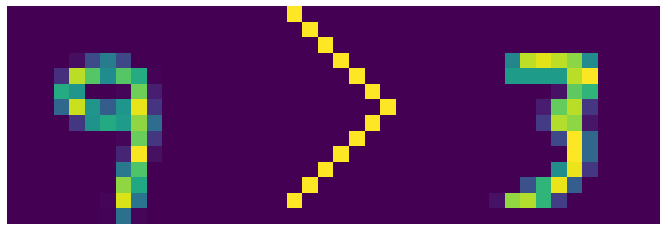

In [4]:
from utils import show_pair
show_pair(train_input, train_target, 0)

## Without using the information from the classes

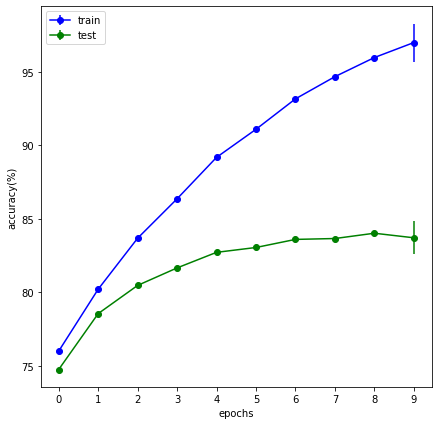

In [6]:
from utils import train_model
from utils import visualize_accuracy
from models.net1 import Net1

mini_batch_size = 100
nb_epochs = 10
eta = 1e-3

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies, test_accuracies, train_losses = [], [], []
for i in range(nb_iter):

    # create model & optimizer
    model = Net1()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    
    # train model
    train_accuracy, test_accuracy, train_loss = train_model(model, 
                                                        train_input, train_target.float(),
                                                        test_input, test_target,
                                                        nb_epochs, mini_batch_size,
                                                        optimizer, criterion)
    
    # add accuracy stats
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    
visualize_accuracy(train_accuracies, test_accuracies, train_losses)

In [7]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 24425 trainable parameters


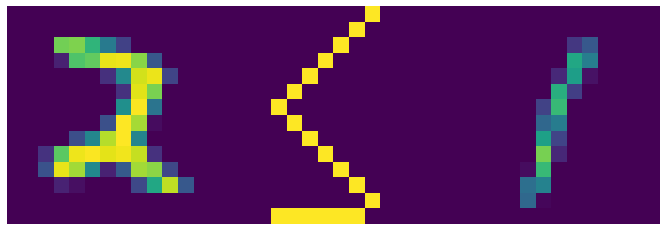

In [9]:
from utils import show_pair
predictions = model(test_input)
show_pair(test_input, predictions, 10)

## With class information during training

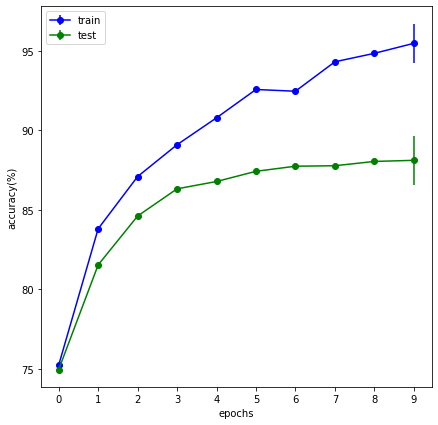

Accuracy of subnetwork for digit classification is on average: 94.84


In [15]:
from utils import train_model_double_objective
from utils import accuracy_of_digit_class
from models.net2 import Net2

mini_batch_size = 10
nb_epochs = 10
eta = 1e-3

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies, test_accuracies, train_losses = [], [], []
sub_dc_accuracy = []
for i in range(nb_iter):
    
    # create model & optimizer
    model = Net2()
    criterion = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

    # train model
    train_accuracy, test_accuracy, train_loss = train_model_double_objective(model, train_input, train_target.float(), 
                                                     train_classes, test_input, test_target, 
                                                     test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                     criterion, criterion2, beta = 1)
    
    # add accuracy stats
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    
    # accuracy of subnetwork for digit classification
    sub_dc_accuracy.append(accuracy_of_digit_class(model, test_input, test_classes))
    
visualize_accuracy(train_accuracies, test_accuracies, train_losses)
mean_sub_dc_accuracy = torch.mean(torch.tensor(sub_dc_accuracy))
print("Accuracy of subnetwork for digit classification is on average: {:.2f}".format(mean_sub_dc_accuracy))

## Net2 with pretrained digit classifier

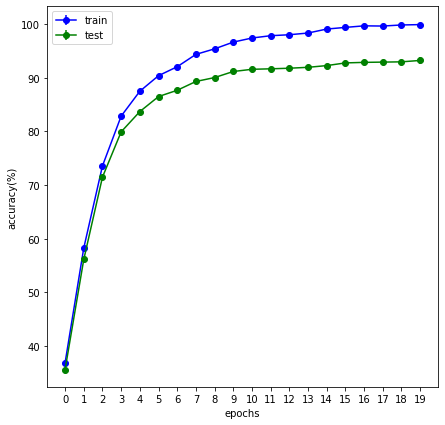

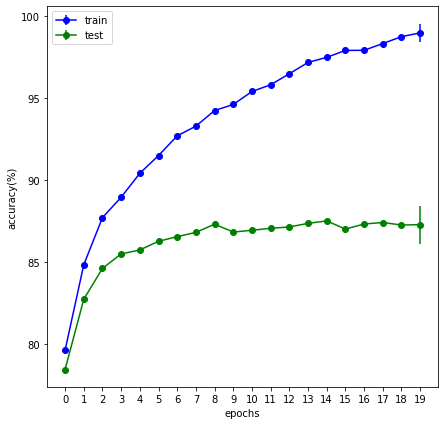

Accuracy of digit classifier after training net2 is on average: 94.91


In [13]:
import torch
from torch import nn
from utils import train_model
from utils import train_model_double_objective
from utils import dfs_freeze
from utils import accuracy_of_digit_class
from models.digit_classifier import DigitClassifier
from models.net2 import Net2

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net2 params
eta_net2 = 1e-3
mini_batch_size_net2 = 10
nb_epochs_net2 = 10

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies_dc, test_accuracies_dc, train_losses_dc = [], [], []
train_accuracies_net2, test_accuracies_net2, train_losses_net2 = [], [], []
dc_accuracy_post_train = []
for i in range(nb_iter):
    
    # create digit classifier model & optimizer
    model_classifier = DigitClassifier(out_h = 10, subnet = False)
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
    criterion = nn.CrossEntropyLoss()

    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    
    # data for digit classifier
    train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
    train_class = train_classes[:,0]
    test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
    test_class = test_classes[:,0]

    # train digit classifier model
    train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                            train_in, train_class,
                                                            test_in, test_class,
                                                            nb_epochs_dc, mini_batch_size_dc, 
                                                            optimizer, criterion)
    
    # add digit classifier accuracy stats
    train_accuracies_dc.append(train_accuracy_dc)
    test_accuracies_dc.append(test_accuracy_dc)
    train_losses_dc.append(train_loss_dc)
    
    # create net2 model & optimizer
    # freeze weights of pre-trained digit classifier
    #dfs_freeze(model_classifier)
    model = Net2(model_classifier)
    criterion = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=eta_net2)
    
    # train net2 model
    train_accuracy_net2, test_accuracy_net2, train_loss_net2 = train_model_double_objective(model, train_input, train_target.float(), 
                                                             train_classes, test_input, test_target, 
                                                             test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                             criterion, criterion2, beta = 1)
    
    # add net2 accuracy stats
    train_accuracies_net2.append(train_accuracy_net2)
    test_accuracies_net2.append(test_accuracy_net2)
    train_losses_net2.append(train_loss_net2)
    
    # accuracy of digit classifier after training net2
    dc_accuracy_post_train.append(accuracy_of_digit_class(model, test_input, test_classes))
    
visualize_accuracy(train_accuracies_dc, test_accuracies_dc, train_losses_dc)
visualize_accuracy(train_accuracies_net2, test_accuracies_net2, train_losses_net2)
mean_dc_accuracy_post_train = torch.mean(torch.tensor(dc_accuracy_post_train))
print("Accuracy of digit classifier after training net2 is on average: {:.2f}".format(mean_dc_accuracy_post_train))

In [5]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 11 trainable parameters


In [17]:
import torch
from torch import nn
from utils import train_model
from utils import train_model_double_objective
from utils import dfs_freeze
from utils import accuracy_of_digit_class
from models.digit_classifier import DigitClassifier
from models.net3 import Net3

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net3 params
eta_net3 = 1e-3
mini_batch_size_net3 = 100
nb_epochs_net3 = 20

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies_dc, test_accuracies_dc, train_losses_dc = [], [], []
train_accuracies_net3, test_accuracies_net3, train_losses_net3 = [], [], []
dc_accuracy_post_train = []
for i in range(nb_iter):
    
    # create digit classifier model & optimizer
    model_classifier = DigitClassifier(out_h = 10, subnet = False)
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
    criterion = nn.CrossEntropyLoss()

    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    
    # data for digit classifier
    train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
    train_class = train_classes[:,0]
    test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
    test_class = test_classes[:,0]
    
    # train digit classifier model
    train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                            train_in, train_class,
                                                            test_in, test_class,
                                                            nb_epochs_dc, mini_batch_size_dc, 
                                                            optimizer, criterion)
    
    # add digit classifier accuracy stats
    train_accuracies_dc.append(train_accuracy_dc)
    test_accuracies_dc.append(test_accuracy_dc)
    train_losses_dc.append(train_loss_dc)
    
    # create net3 model & optimizer
    # freeze weights of pre-trained digit classifier
    #dfs_freeze(model_classifier)
    model = Net3(nb_residual_blocks = 20, pretrained_submodel = model_classifier,
                 c1 = 32, c2 = 32, c3 = 64, h = 100, p = 0.3,
                 hidden_channel_1 = 1, hidden_channel_2 = 10)
    criterion = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = eta_net3)
    
    # train net3 model
    train_accuracy_net3, test_accuracy_net3, train_loss_net3 = train_model_double_objective(model, train_input, train_target, 
                                                                     train_classes, test_input, test_target, test_classes, 
                                                                     nb_epochs_net3, mini_batch_size_net3, optimizer, criterion, criterion2, 
                                                                     beta = 1)
    
    # add net3 accuracy stats
    train_accuracies_net3.append(train_accuracy_net3)
    test_accuracies_net3.append(test_accuracy_net3)
    train_losses_net3.append(train_loss_net3)
    
    # accuracy of digit classifier after training net3
    dc_accuracy_post_train.append(accuracy_of_digit_class(model, test_input, test_classes))
    
visualize_accuracy(train_accuracies_dc, test_accuracies_dc, train_losses_dc)
visualize_accuracy(train_accuracies_net3, test_accuracies_net3, train_losses_net3)
mean_dc_accuracy_post_train = torch.mean(torch.tensor(dc_accuracy_post_train))
print("Accuracy of digit classifier after training net2 is on average: {:.2f}".format(mean_dc_accuracy_post_train))   

KeyboardInterrupt: 

In [ ]:
from utils import num_of_train_param
num_of_train_param(model)

## Simple convolutional network

/home/relja/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


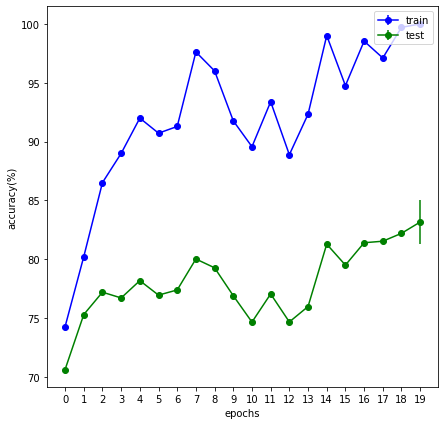

In [3]:
from models.convnet import ConvNet
from utils import train_model
from utils import visualize_accuracy
from dlc_practical_prologue import generate_pair_sets

nSamples = 1000
nb_epochs = 20
mini_batch_size = 100

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies, test_accuracies, train_losses = [], [], []
for i in range(nb_iter):
    
    # create model & optimizer
    model = ConvNet(nb_channels=48, kernel_size=3, weight_sharing=False)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    criterion = nn.BCELoss()            
        
    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    # pad input to size 16 x 16 (power of 2, so that it can be run through 3 max-pool layers)
    train_input_cnn = torch.nn.functional.pad(train_input, (1, 1, 1, 1), 'constant', 0)
    test_input_cnn = torch.nn.functional.pad(test_input, (1, 1, 1, 1), 'constant', 0)
    
    # train model
    train_accuracy, test_accuracy, train_loss = train_model(model, 
                                            train_input_cnn, train_target.float(),
                                            test_input_cnn, test_target,
                                            nb_epochs, mini_batch_size,
                                            optimizer, criterion)
    # add accuracy stats
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)

visualize_accuracy(train_accuracies, test_accuracies, train_losses)

In [7]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 117265 trainable parameters
